# Connect to drive

To begin we will connect to Google Drive, which will be useful later to upload the dataset we already have in our Google Drive corresponding folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

After uploading the dataset we are going to import some libraries that will come in handy for the different phases of our analysis:

In [2]:
#visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn-whitegrid')
import seaborn as sns #based on matplotlib
import os

#for basic manipulation
import pandas as pd
import numpy as np

#for machine-learning (scikit-learn)
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.over_sampling import SMOTE




<ipython-input-2-be2b7907542b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Pre-processing of the data

Now we can start the pre-processing, that involves transforming raw structured data into a structured format that is more suitable for subsequent analysis and modelling:

In [3]:
#Get the dataset from Google Drive
dataset = pd.read_csv("/content/drive/MyDrive/DATA SCIENCE 23 24/FDS_Final_Project/healthcare-dataset-stroke-data.csv")

In [4]:
# Inspect the dataset
dataset.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Since we already have a small dataset, 5110 rows, deleting 201 Na's isn't the smartest choice. Therefore we decide to fill the missing values with the mean of the avaliable values.

In [5]:
#Replaces the missing values in the 'bmi' column with the mean of the available values
dataset.bmi.fillna(dataset.bmi.mean(), inplace=True)

In [6]:
#Let's check if the compiled succesfully
dataset.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

> We can see that there are no missing values anymore

Now let's have a look at the unique values of each variable of the dataset:

In [7]:
#Get the unique values that will be outputed as a series object
unique_values = pd.Series({col: dataset[col].unique() for col in dataset.columns})

#convert the series into a dataframe
unique_values_df = unique_values.to_frame()
unique_values_df

,0
id,"[9046, 51676, 31112, 60182, 1665, 56669, 53882..."
gender,"[Male, Female, Other]"
age,"[67.0, 61.0, 80.0, 49.0, 79.0, 81.0, 74.0, 69...."
hypertension,"[0, 1]"
heart_disease,"[1, 0]"
ever_married,"[Yes, No]"
work_type,"[Private, Self-employed, Govt_job, children, N..."
Residence_type,"[Urban, Rural]"
avg_glucose_level,"[228.69, 202.21, 105.92, 171.23, 174.12, 186.2..."
bmi,"[36.6, 28.893236911794666, 32.5, 34.4, 24.0, 2..."


Looking at the unique values we can start by checking the folllwing things:
1. See if the percentage of "Other" in the "gender" column with respect to "Male" and "Female" is small enough to be deleted.

2. Look for negative values in the "age", "bmi" and "avg_glucose_level" columns, that in case won't be acceptable levels.

1) Percentage of "Other" with respect to "Female" and "Male"

In [8]:
n_Others =sum(dataset['gender'] =='Other')
n_Female =sum(dataset['gender'] =='Female')
n_Male =sum(dataset['gender'] =='Male')

print("We can see that we have just " + str(n_Others) + " 'Other' gender value, while we have " + str(n_Female) + " females and " + str(n_Male) + " males.\nThe 'Other' value can be deleted from the dataset.")

We can see that we have just 1 'Other' gender value, while we have 2994 females and 2115 males.
The 'Other' value can be deleted from the dataset.


In [9]:
# It removes the single row where the 'gender' column has the value 'Other'
dataset.drop(dataset.loc[dataset['gender'] =='Other'].index, inplace=True)

2)  Let's see the potential negative values of "age", "bmi" and "avg_glucose_level"

In [10]:
# Check if there are negative values in the 'age', 'bmi', and 'avg_glucose_level' columns
negative_values = dataset[(dataset['age'] < 0) | (dataset['bmi'] < 0) | (dataset['avg_glucose_level'] < 0)]
len(negative_values)

0

> From the obtained result we can see that there are no negative values for the selected  columns

Now that we had a more in-depth look at our dataset we can move forward and start a descriptive statistical analysis to have a better understanding of our variables and our dataset in general.

# Descriptive statistical analysis

> Let's get the dataset informations first

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   float64
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   Residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                5109 non-null   float64
 10  smoking_status     5109 non-null   object 
 11  stroke             5109 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 518.9+ KB


> And now let's see better what kind of variables we have in our dataset

In [12]:
dataset.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


# **Plots**

> ### ***Boxplot***

After analyzing the types of variables in our dataset, we decided to use a boxplot to visualize the distribution of the numerical variables, because these type of graphs are an effective tool for summarizing the distribution of the data. They also provide some statistical indicators, like the quartiles, the median, and the whiskers that extend from the box to the minimum and maximum data points. \\
Boxplots can also help identify outliers, which are data points that significantly differ from other observations.


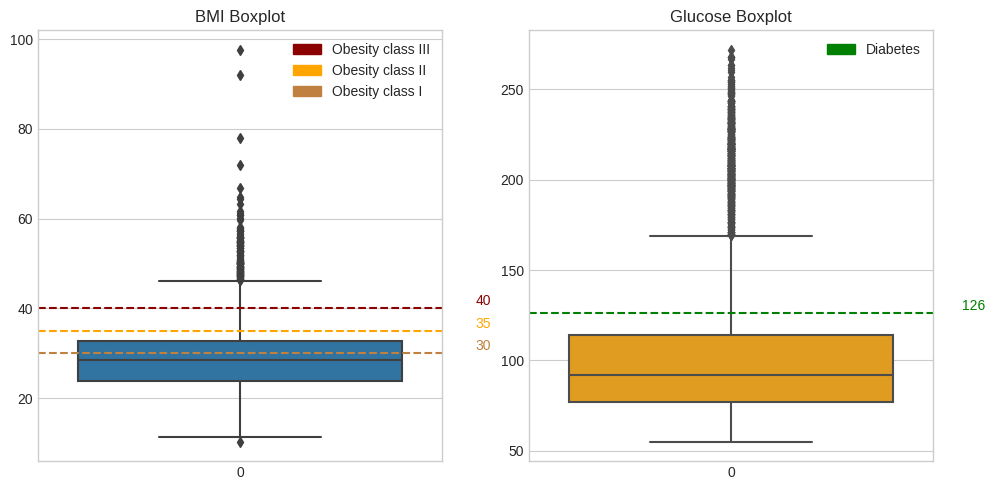

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot for BMI (Body Mass Index)
sns.boxplot(data=dataset['bmi'], ax=axs[0])
axs[0].set_title('BMI Boxplot')
axs[0].axhline(30, color=(0.75, 0.5, 0.25), linestyle='--')
axs[0].text(0.6, 30, '30', ha='center', va='bottom', color=(0.75, 0.5, 0.25))
axs[0].axhline(35, color='orange', linestyle='--')
axs[0].text(0.6, 35, '35', ha='center', va='bottom', color='orange')
axs[0].axhline(40, color='darkred', linestyle='--')
axs[0].text(0.6, 40, '40', ha='center', va='bottom', color='darkred')

# Boxplot for average glucose level
sns.boxplot(data=dataset['avg_glucose_level'], ax=axs[1], color = "orange")
axs[1].set_title('Glucose Boxplot')
axs[1].axhline(126, color='green', linestyle='--')
axs[1].text(0.6, 126, '126', ha='center', va='bottom', color='green')

# Create legend handles
red_patch = mpatches.Patch(color='darkred', label='Obesity class III')
light_brown_patch = mpatches.Patch(color=(0.75, 0.5, 0.25), label='Obesity class I')
orange_patch = mpatches.Patch(color='orange', label='Obesity class II')
green_patch = mpatches.Patch(color='green', label='Diabetes')

# Add a legend
axs[0].legend(handles=[red_patch, orange_patch, light_brown_patch], loc='upper right')
axs[1].legend(handles=[green_patch], loc='upper right')


# Show the plot
plt.tight_layout()
plt.show()


We notice a high number of outliers in both distributions. To interpret these boxplots accurately, it's essential to understand the relationship between glucose levels and diabetes. Diabetes can often be diagnosed through blood glucose measurements.

Let's consider these standard values:

- Venous blood glucose concentration: 3.9 – 5.5 mmol/l (70-100 mg/dl)
- Capillary blood glucose concentration: 4.4 – 6.1 mmol/l (80-110 mg/dl)
- Plasma blood glucose concentration: 4.2 – 6.4 mmol/l (75-115 mg/dl)
- Blood glucose level value for diabetes diagnosis: 7.8 mmol/l (140 mg/dl)

The diagnosis of diabetes mellitus occurs when blood glucose levels reach or exceed 126 mg/dl. [[1]](https://www.laleggepertutti.it/260422_diabete-i-valori-di-riferimento-della-glicemia)

These values provide insight into the outliers in the average glucose level distribution. Most likely, these individuals may have diabetes or are at risk of developing diabetes-related complications.

Now, let's turn to the BMI boxplot where we can apply a similar reasoning. Given these BMI categories [[2]](https://www.salute.gov.it/portale/nutrizione/dettaglioIMCNutrizione.jsp?lingua=italiano&id=5479&area=nutrizione&menu=vuoto):

- Underweight: 16.00 - 18.49
- Normal weight: 18.50 - 24.99
- Overweight: 25.00-29.99
- Obesity class 1: 30.00-34.99
- Obesity class 2: 35.00-39.99
- Obesity class 3: ≥ 40.00

The outliers in our population are likely those who are considered obese or overweight.

> ### ***Barplot***

Now we can plot the barplots for the categorical variables. \\
Barplots are a good way to represent categorical data because they allow you to visualize the distribution of categorical variables by comparing the counts or frequencies of each category.

In a barplot, each category is represented by a bar, and the length or height of the bar corresponds to the count or frequency of that category. This makes it easy to compare the counts or frequencies of different categories at a glance

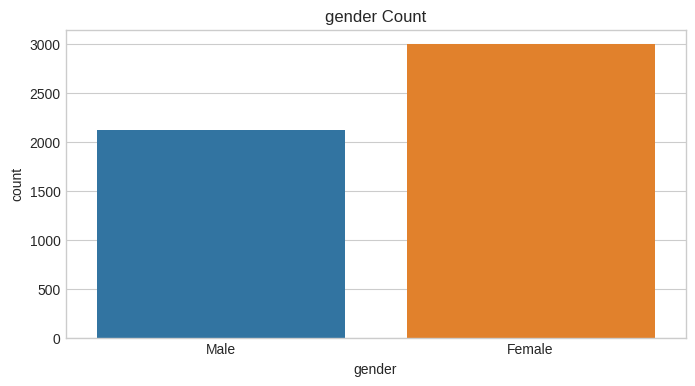

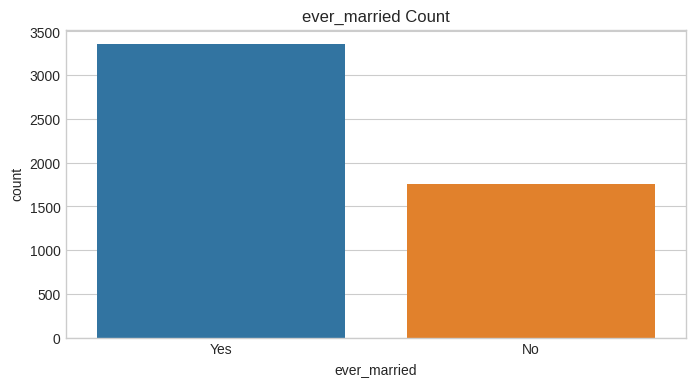

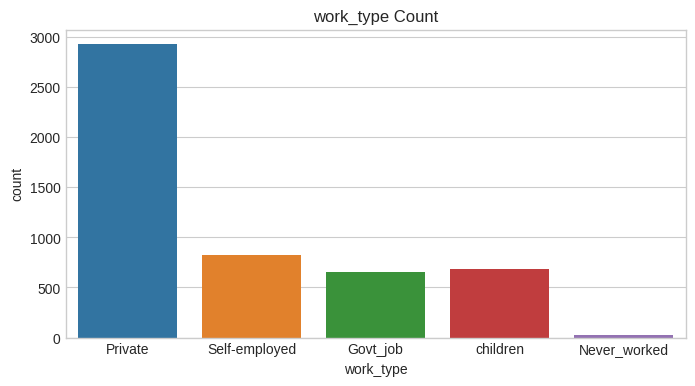

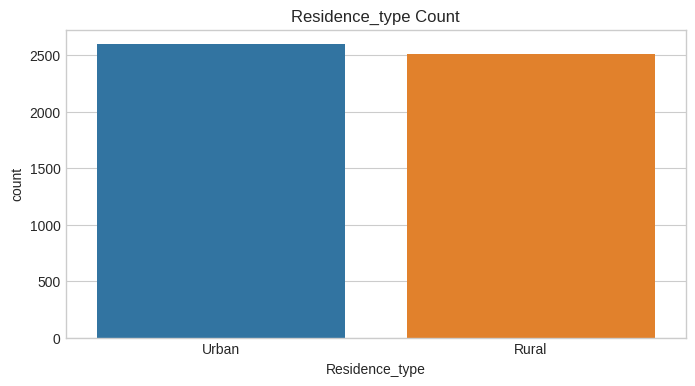

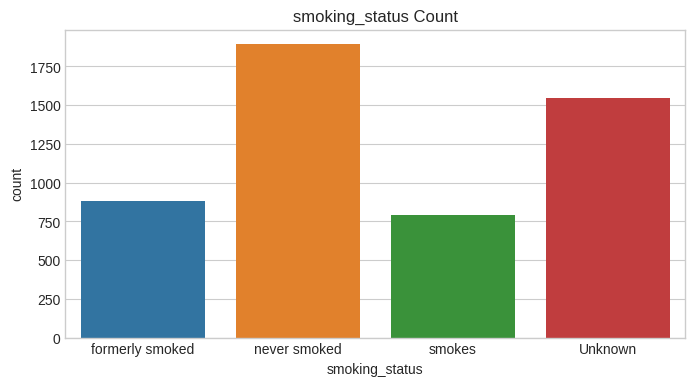

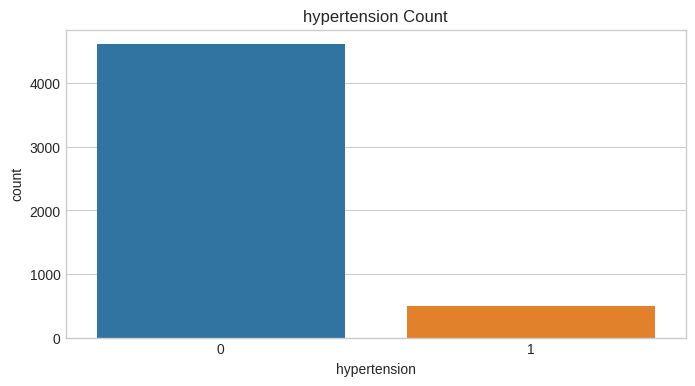

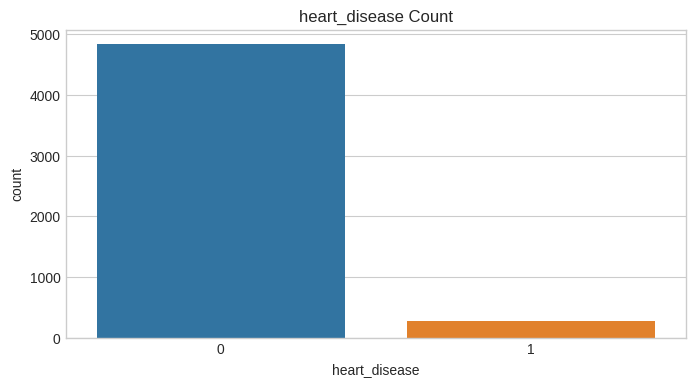

In [14]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','hypertension', 'heart_disease']
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=dataset, x=column)
    plt.title(f'{column} Count')
    plt.show()

> ### ***Heatmap***

A heatmap is a graphical representation of data where individual values contained in a matrix are represented as colors. It is often used to visualize complex data sets with two variables: the value of each variable for each observation is represented as color on a map. This can be useful to identify patterns and correlations in the data.

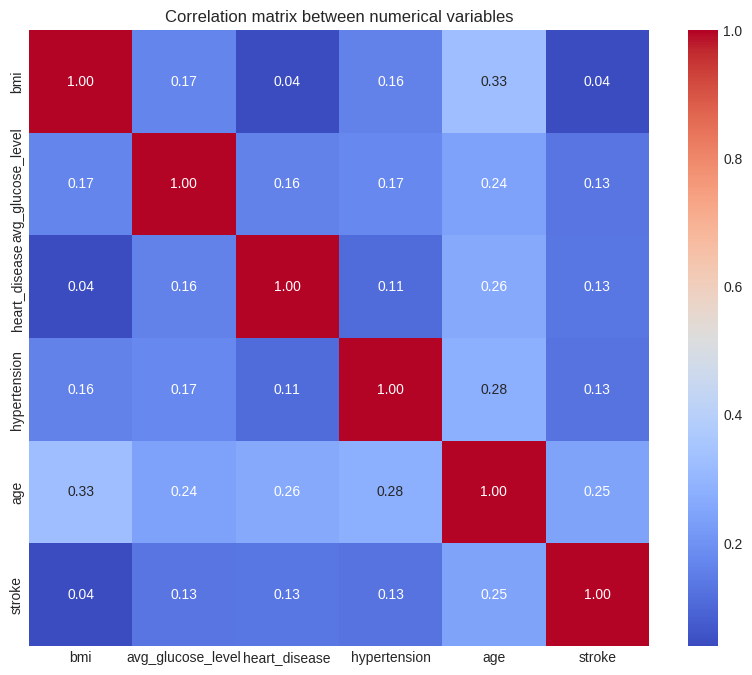

In [15]:
#Correlation
numeric_columns = ["bmi", "avg_glucose_level", "heart_disease", "hypertension", "age", "stroke"]
plt.figure(figsize=(10, 8))
sns.heatmap(dataset[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix between numerical variables')
plt.show()

We can observe that we have an overall weak-to-moderate positive correlation between the variables. \\
With a more in-depth analysis we can see that we have a moderate correlation between age and bmi, age and stroke, age and hypertension, age and haeart_disease, age and glucose_level. Basically with the 'age' variable and all the other ones we took into consideration for the heatmap.

These are all results that we expected, since it's natural that older people usually have more health problems and are therefore more at risk of stroke and similar.

We can also observe that bmi and stroke have a really weak correlation, this means that having an high or low BMI doesn't necessarly influence the possibility of having a stroke.

It's important to note, though, that correlation does not necessarily imply causation. The results of the heatmap provide evidence for a potential association, but further investigation is needed to determine the exact relationship between these variables.

> ### ***Pieplot***

Now we can move forward with our statistical analisys and perform a pieplot on the 'stroke' variable. \\
We decided to use a piechart for this variable because it's a good way to visualize and have an idea of how many people had or not a stroke.

In [16]:
df=dataset.copy()

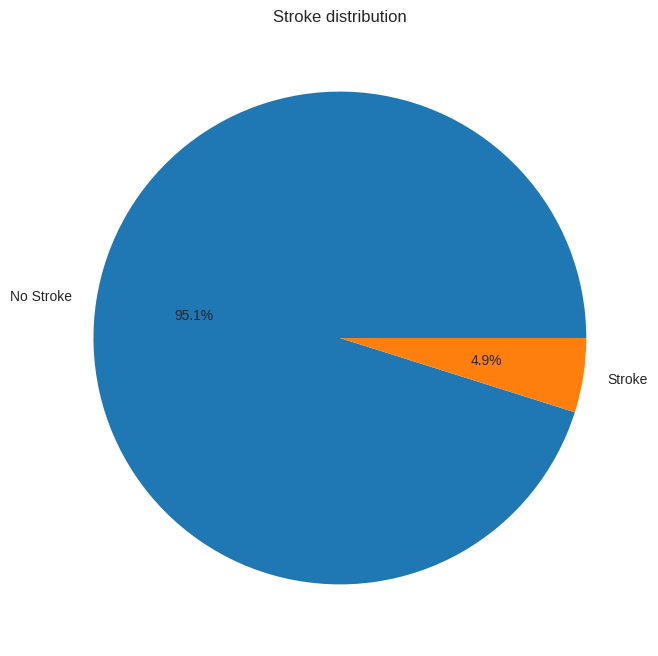

In [17]:
plt.figure(figsize=(8, 8))
df['stroke_label'] = df['stroke'].map({1: 'Stroke', 0: 'No Stroke'})
stroke_distribution = df['stroke_label'].value_counts()
plt.pie(stroke_distribution, labels=stroke_distribution.index, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
plt.title('Stroke distribution')
plt.show()


Here we can clearly see how many people do not have stroke in our dataset, 95.1%, which is quite a lot

Given the previous graphs it would be interesting to see the variables ratio with respect to the stroke:

<Figure size 1000x600 with 0 Axes>

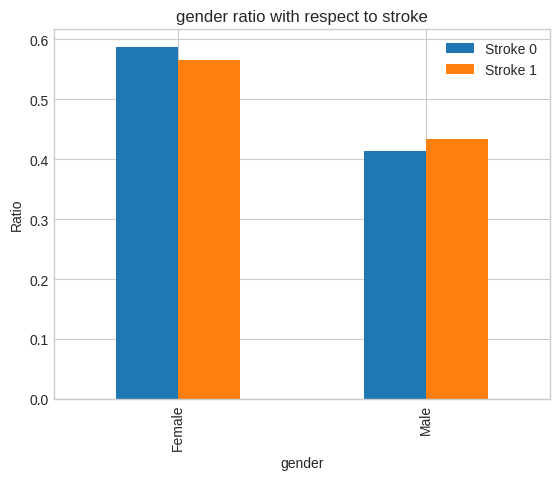

<Figure size 1000x600 with 0 Axes>

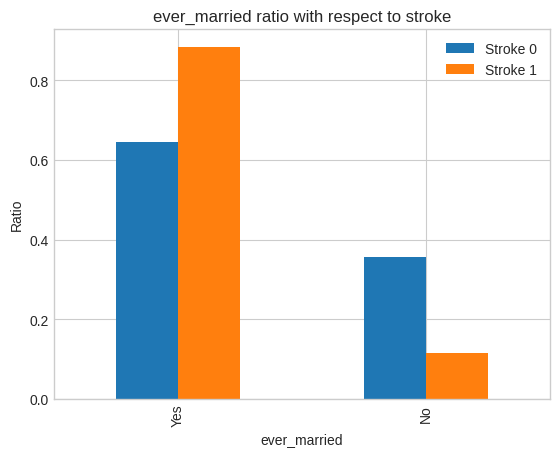

<Figure size 1000x600 with 0 Axes>

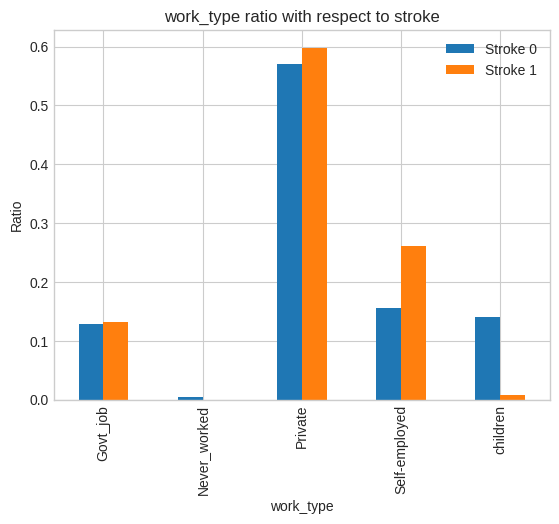

<Figure size 1000x600 with 0 Axes>

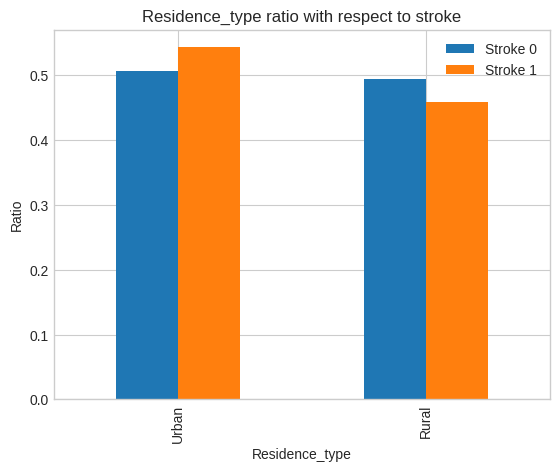

<Figure size 1000x600 with 0 Axes>

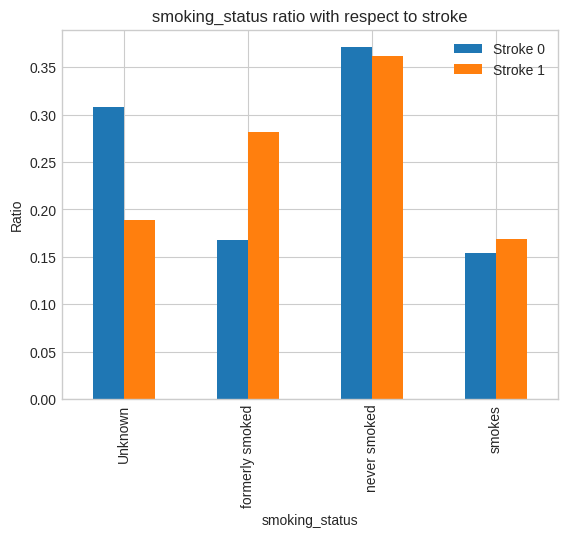

<Figure size 1000x600 with 0 Axes>

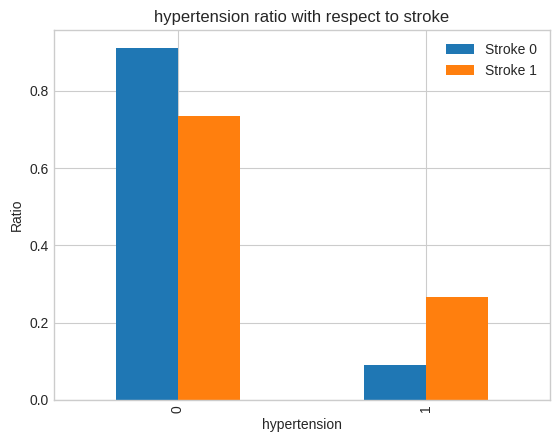

<Figure size 1000x600 with 0 Axes>

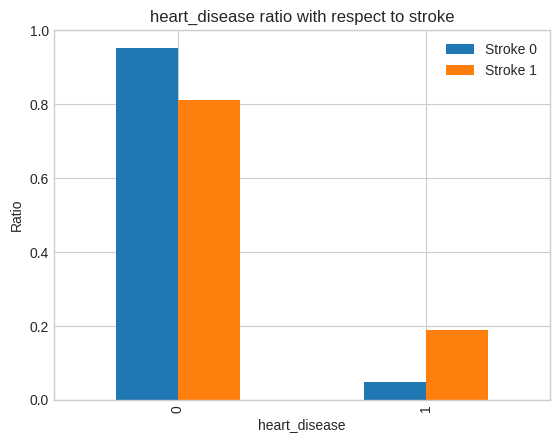

In [18]:
for column in categorical_columns:
    plt.figure(figsize=(10, 6))

    # Compute the ratio between the number of y with that mode and the number of those with stroke=0
    counts_stroke_0 = df[df['stroke'] == 0][column].value_counts()
    total_stroke_0 = df[df['stroke'] == 0].shape[0]
    ratio_stroke_0 = counts_stroke_0 / total_stroke_0

    # Compute the ratio between the number of y with that mode and the number of those with stroke=1
    counts_stroke_1 = df[df['stroke'] == 1][column].value_counts()
    total_stroke_1 = df[df['stroke'] == 1].shape[0]
    ratio_stroke_1 = counts_stroke_1 / total_stroke_1

    # Unify the previously computed dataframes
    ratio_df = pd.DataFrame({
        'Stroke 0': ratio_stroke_0,
        'Stroke 1': ratio_stroke_1
    })

    ratio_df.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
    plt.title(f'{column} ratio with respect to stroke')
    plt.ylabel('Ratio')
    plt.xlabel(column)
    plt.show()

To interpret this data, let's start by examining the gender ratio concerning stroke. We find a higher count of female subjects, and when comparing stroke subtypes, the male to female gender ratio is significantly higher in Stroke 1 (those who have had a stroke) compared to Stroke 0 (those who haven't had a stroke). This suggests that certain factors related to the severity or type of stroke might be influencing the gender ratio. Furthermore, the data indicates a higher prevalence of male patients in stroke cases.

Next, let's focus on the impact of smoking habits. Research indicates that smokers are significantly more prone to experiencing a stroke compared to those who abstain from smoking. \\
According to a study from the British Heart Foundation, smokers are nearly twice as likely to face a stroke as non-smokers. This heightened risk is attributed to the harmful effects of smoking on blood vessels and the subsequent decrease in blood flow to the brain caused by smoking [[3]](https://www.stroke.org.uk/resources/smoking-and-risk-stroke).\\
Moreover, another study discloses that the likelihood of suffering a stroke rises by 12% for each additional five cigarettes consumed daily [[4]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6708836/). \\
These studies provide evidence supporting the observation reflected in the barplot, suggesting a strong relationship between smoking and the risk of stroke.

Similarly, patients with high blood pressure are significantly more likely to experience a stroke compared to those without hypertension. \\
A study published in the Journal of Clinical Hypertension states that high blood pressure is the single most important culprit behind cerebrovascular diseases and the most prevalent modifiable risk factor [[5]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8030455/).

Looking at heart disease versus stroke, patients with heart disease have a higher probability of experiencing a stroke compared to those without heart disease. \\
A study from the National Center for Biotechnology Information (NCBI) supports this, stating that heart disease is a significant risk factor for stroke [[6]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9721101/). The article further explains that stroke patients with heart failure exhibit higher neurological deficits at admission and discharge from the hospital and this phenomenon continues even three months following the stroke.

Based on the graphs, we can conclude that married patients have a higher probability of experiencing a stroke than single patients, and those living in urban areas have a higher probability of experiencing a stroke compared to those living in rural areas. This might be due to other factors associated with the risk of stroke rather than directly related to being married or living in urban areas.

Finally, for the work_type variable, from the bar plot we can see that self-employed or professionals have a slightly higher risk of experiencing a stroke compared to those in technical, sales, or administrative jobs. However, these results might not be directly related to the work type, but rather to other associated factors that have a higher correlation with stroke.

--------------------------------------------------------------------------------

# Train and split


Before diving into the splitting of the data we will encode the 'Gender', 'Ever Married', and 'Residence Type' variables using 0 and 1. This step is crucial for applying machine learning algorithms to non-numerical variables. \\
The reason behind this is that many machine learning algorithms require numerical input. Non-numerical or categorical data, such as gender, marital status, and residence type, can't be processed directly by these algorithms. To overcome this, we convert these categorical variables into a format that can be understood by the machine learning algorithms.

In [19]:
# RUN ONLY ONE TIME
run = True
if(run):

  # GENDER: F/M --> 1/0
  dataset["gender"] = dataset["gender"].apply(lambda x: 1 if x=="Female" else 0)

  # EVER_MARRIED: YES/NO --> 1/0
  dataset["ever_married"] = dataset["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)

  # RESIDENCE_TYPE: URBAN/RURAL --> 1/0
  dataset["Residence_type"] = dataset["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)

dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,1,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,1,83.75,28.893237,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,1,125.20,40.000000,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,0,82.99,30.600000,never smoked,0
5108,37544,0,51.0,0,0,1,Private,0,166.29,25.600000,formerly smoked,0


We will then proceed with the split of the data

In [20]:
X = dataset.drop(['id', 'stroke'], axis = 1)
y = dataset['stroke']

Then we proceed to define a function that normalises the inputed dataframe. \\
Normalization is a technique that scales the features to a fixed range, usually between 0 and 1. This is useful when the features have different scales, as it ensures that all features contribute equally to the model, regardless of their original scale.

In [21]:
def norm_X(X_total):
    # transform the dataframe in dictionary to perform feature extraction
    X_total = X_total.to_dict('records')

    v = DictVectorizer(sparse = False, dtype = float)
    X_total = v.fit_transform(X_total)
    return X_total, v

In [22]:
#normalize the features
X_big_array = X.copy()
X_big_array, v = norm_X(X_big_array)

X_norm = pd.DataFrame(X_big_array, columns = v.get_feature_names_out())

Then we can divide in train and test to then apply the machine learning algorithms for the prediction.

After applying the KNN algorithm, Logistic Regression and Support vector machine to our data we noticed that they all gave back very bad confusion matrices. This is probably due to the fact that in out dataset we have unbalanced classes: 95.1% of our subjects didn't have a stoke. \\
To try and fix this we applied SMOTE (Synthetic Minority Over-sampling Technique) on the data and re-run the algorithms.

\\
The SMOTE technique is used to handle imbalanced datasets in machine learning, since this imbalance can lead to a model that is biased towards the majority class and performs poorly on the minority class. \\
Instead of simply duplicating existing instances from the minority class, SMOTE synthesizes new instances that are similar to the existing instances but not identical. This is done by selecting two or more similar instances from the minority class, drawing a line between them, and generating a new instance along this line. \\
When using this SMOTE technique, thought, it should be taken into account that applying it to the test data could lead to data leakage, where information from the test set influences the training process, resulting in overly optimistic performance estimates [[7]](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) [[8]](https://www.nature.com/articles/s41598-021-03430-5)

In [23]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_big_array, y.array, test_size=0.33, random_state=100)

# Initialize SMOTE
oversample = SMOTE()

# Apply SMOTE only to the training data
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

In [24]:
print("The non-SMOTE train data has " + str(len(X_train) ) + " observations") #len of the non-SMOTE train data : 3423
print("The SMOTE train data has " + str(len(X_train_res) ) + " observations") #len of the SMOTE train data : 6506
print("So we can see that the train data, after applying the SMOTE, get doubled in number")

The non-SMOTE train data has 3423 observations
The SMOTE train data has 6506 observations
So we can see that the train data, after applying the SMOTE, get doubled in number


We decided to use the KNN algorithm, Logistic Regression and Support vector machine because they have the following strong points:
1. **K-Nearest Neighbors (KNN):** \\
The algorithm is simple and easy to understand.
It can be used for classification or regression tasks.
The algorithm can be effective in high-dimensional spaces.
However, the performance of KNN can be negatively impacted by changes in the data distribution and may not be suitable for large datasets due to its complexity in computation.

2. **Logistic Regression:** \\
The strength of logistic regression lies in its ability to predict a binary outcome (0 or 1) from one or more input variables. Logistic regression can also handle data that is not linearly separable, thanks to its ability to work with the log-odds of the outcome. The model is robust and can provide a good starting point for prediction. However, logistic regression requires a careful choice of features and scaling of data, as it assumes linear relationships between input features and log-odds of the outcome.

3. **Support Vector Machines (SVM):** \\
The strength of SVM lies in its ability to find optimal hyperplanes that maximize the margin between different classes. SVM is particularly effective at dealing with high-dimensional data. The decision function provided by SVMs is also particularly useful for multiclass classification. However, SVMs can be sensitive to the selection of hyperparameters (such as the choice of kernel and regularization parameter C). They can also be slow to train for large datasets, especially when using complex kernels.



Now let's apply them to the data:

### *k-neighbors method*

KNN is a type of algorithm used in machine learning that helps in classifying new data points based on the similarity of the data points in the training set. It does this by looking at the 'k' closest data points in the training set to the new data point and making a prediction based on these 'k' closest points

Before starting with the knn method, we will define a function that computes the performance evaluation metrics that we will need later to evaluate the various model's performance we will use

In [26]:
def calculate_performance(mat):
  # values of our confusion matrix
  TN, FP, FN, TP = mat.ravel()

  # Calculate Precision, Recall e F1-Score
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1_score = 2 * (precision * recall) / (precision + recall)

  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-Score: {f1_score:.4f}')

*Elbow method for optimal number of neighbors*

Before applying the KNN regressor we can use the Elbow Method to find the optimal number of neighbors. \\
The elbow method is a technique used to determine the optimal number of components in Principal Component Analysis (PCA). It is a method that involves plotting the explained variance as a function of the number of components and identifying the point where the curve begins to bend, often referred to as the "elbow" of the curve. This point is typically chosen as the optimal number of components to retain, as adding more components does not significantly increase the explained variance. \\
This method can be adapted to the case of finding the optimal number of neighbors following the exact same reasoning, but with the the test error instead of the explained variance. So basically, our optimal numer of neighbors is the one that minimizes the test error.

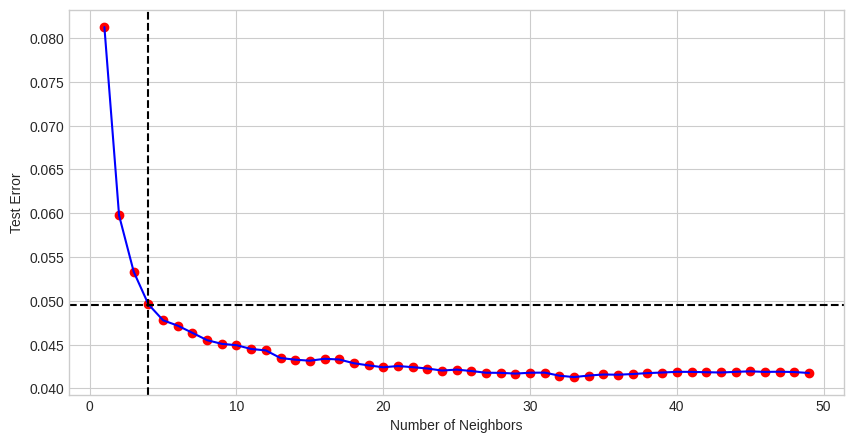

In [27]:
# List to hold test errors
errors = []

# Range of possible values for n_neighbors
possible_values = range(1, 50)

# For each possible value of n_neighbors
for n in possible_values:
   # Create a KNN regressor with n_neighbors = n
   knn = KNeighborsRegressor(n_neighbors=n)

   # Fit the model to the training data
   knn.fit(X_train, y_train)
   #knn.fit(X_train_res, y_train_res) #for SMOTE train set

   # Use the fitted model to predict the test data
   y_pred = knn.predict(X_test)

   # Compute the test error
   mse = mean_squared_error(y_test, y_pred)
   errors.append(mse)

# Plot the test errors
plt.figure(figsize=(10, 5))
plt.plot(possible_values, errors, color='blue')
plt.scatter(possible_values, errors, color='red')
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Error')
plt.axvline(x=4, color='black', linestyle='--')
plt.axhline(y= 0.0495, color='black', linestyle='--')
#plt.axvline(x=4 , color='black', linestyle='--') #for SMOTE train set
#plt.axhline(y=0.157 , color='black', linestyle='--') #for SMOTE train set
plt.show()

As we can see from the graph, the number of neighbors that minimzes the test error is equal to 4, for both the SMOTE (with minimal test error = 0.157) and non-SMOTE (with minimal test error =0.0495) train data. \\
Now we can proceed with the KNN regressor:

In [28]:
knn_regressor = KNeighborsRegressor(n_neighbors=4)

In [29]:
# Train the classifier on the training data
#knn_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train_res, y_train_res) #SMOTE train set

KNeighborsRegressor(n_neighbors=4)

In [30]:
# Predictions on the dataset's data
y_pred = knn_regressor.predict(X_test)

In [31]:
# Convert y_pred to int type
y_pred = y_pred.astype(int)

#performance metrics to evaluate the model's performance:
accuracy_knn = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred) #generates a text report showing the main classification metrics
mat_knn = confusion_matrix(y_test, y_pred) #computes the confusion matrix

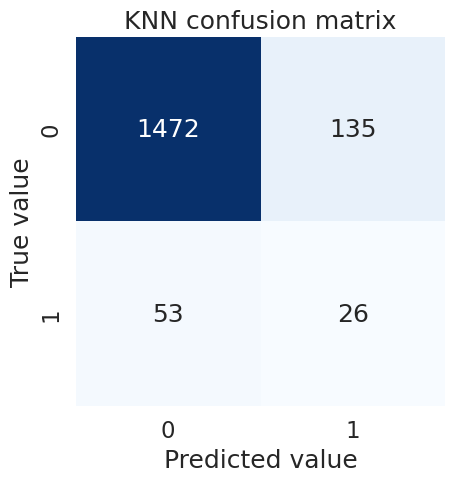

In [32]:
#Confusion matrix

sns.set(font_scale=1.5)
sns.heatmap(mat_knn, square=True, annot=True, cbar=False, fmt="d", cmap="Blues")
plt.title("KNN confusion matrix")
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()

Now let's compute some performance evaluation metrics:

In [33]:
#The following computes the precision, recall and the F1_score
calculate_performance(mat_knn)

Precision: 0.1615
Recall: 0.3291
F1-Score: 0.2167


In [34]:
#Accuracy metric
print(accuracy_knn)

0.8884934756820878


### *Support vector machine*

Support Vector Machine (SVM) is a powerful machine learning model used for both classification and regression problems. It works by finding a hyperplane that best separates the data points of different classes. The goal is to find the optimal hyperplane that maximizes the margin between the closest points of different classes. Essentially, it's a decision boundary that helps separate the classes in the data.

In [35]:
# create the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)  # Puoi personalizzare il kernel e i parametri C a seconda delle tue esigenze

# Train the classifier on the training data
#svm_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train_res, y_train_res) #SMOTE train set

# Predictions on the test data
y_pred = svm_classifier.predict(X_test)


# Evaluate the model's performance with the following performance evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred) #generates a text report showing the main classification metrics
mat_svm = confusion_matrix(y_test,y_pred) #computes the confusion matrix

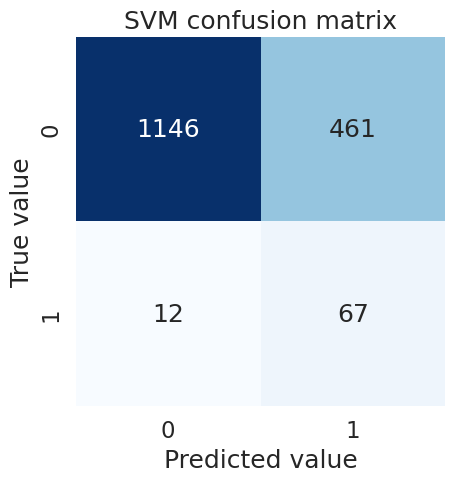

In [36]:
#Confusion matrix
sns.set(font_scale=1.5)
sns.heatmap(mat_svm, square=True, annot=True, cbar=False, fmt="d", cmap="Blues")
plt.title("SVM confusion matrix")
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()

In [37]:
#The following computes the precision, recall and the F1_score
calculate_performance(mat_svm)

Precision: 0.1269
Recall: 0.8481
F1-Score: 0.2208


In [38]:
#Accuracy metric
print(accuracy_svm)

0.7194543297746144


### *Logistic Regression*

Logistic regression is a statistical model that is used to predict the probability of an event occurring. It's commonly used in binary classification problems where the output is either success or failure. It uses a logistic function to model the probability of the occurrence of an event, given a set of independent variables.

In [39]:
# create the Logistic Regression classifier
clf = LogisticRegression(random_state=0)

# Train the classifier on the training data
#clf.fit(X_train, y_train)
clf.fit(X_train_res, y_train_res) #SMOTE train set

# Predicions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance with the following performance evaluation metrics
accuracy_clf = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred) #generates a text report showing the main classification metrics
mat_lr = confusion_matrix(y_test,y_pred) #computes the confusion matrix

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


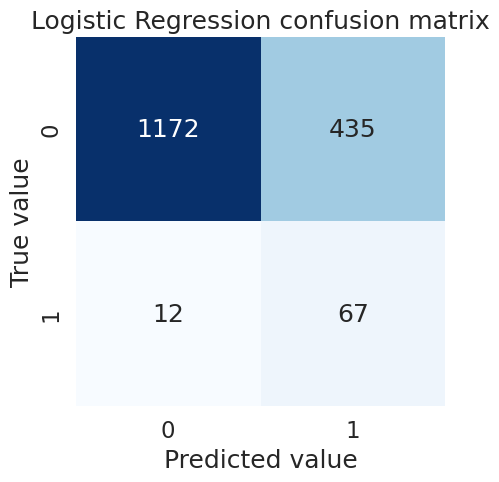

In [40]:
#Confusion matrix
sns.set(font_scale=1.5)
sns.heatmap(mat_lr, square=True, annot=True, cbar=False, fmt="d", cmap="Blues")
plt.title("Logistic Regression confusion matrix")
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()

In [41]:
#The following computes the precision, recall and the F1_score
calculate_performance(mat_lr)

Precision: 0.1335
Recall: 0.8481
F1-Score: 0.2306


In [42]:
#Accuracy metric
print(accuracy_clf)

0.7348754448398577


From the results of both the confusion matrices and the performance evaluation metrics we can undoubtly see that the algorithms aplied on the SMOTE dataset have way worse accuracy than without applying SMOTE. This kind of result can be due to:

**Overfitting:** One possibility is that we might be oversampling too much. When generating synthetic samples, noise or bias can be introduced into your dataset, leading to overfitting. Overfitting occurs when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. \\
**Overlapping:** Another possibility is that SMOTE is generating synthetic points that overlap with the real data, causing issues with the model's ability to distinguish between different classes. This could potentially harm the model's performance. \\
**Model sensitivity:** Some models might be sensitive to the presence of synthetic samples. If this is the case, even though the model is being oversampled, the synthetic samples might still cause the model to underperform.

--------------------------------------------------------------------------------

After trying out machine learning algorithms on the smoothed dataset and computing performance evaluation metrics, since the smoothing creates a false datset an alternative solution to fix the unbalanced dataset could be model combination.

\\
Model combination, also known as stacking or model averaging, is an ensemble learning method where the predictions of multiple base models are combined to improve the predictive performance of the model. This technique is often used when dealing with multiple models that are based on different assumptions or algorithms, and it aims to improve the prediction performance by leveraging the strengths of all models.

In the context of predicting whether someone has a stroke or not, Logistic Regression, K-Nearest Neighbors (KNN), and Support Vector Machines (SVM) are used. Each of these models has its own strengths and weaknesses, and combining them could potentially improve the overall prediction performance.

The basic steps of model combination are as follows:

1. **Train individual models**: First, train a Logistic Regression, KNN, and SVM model on your dataset. Each of these models would learn to predict whether a person has a stroke based on the input features.
2. **Generate predictions**: Next, use each of these models to generate predictions on your test data.
3. **Combine predictions**: Finally, combine these predictions in some way to generate the final prediction. One simple way to do this is to take the majority vote of the predictions from each model.

This approach is a powerful technique that can often improve the prediction performance of the models. By combining the predictions of multiple models, it can often achieve better results than any single model, especially when the models are based on different assumptions or algorithms

So we will combine the strength of the KNN algorithm, Logisitc Regression and to have a model with improved predictive model and that will, hopefully, help us solve the problem of the unbalanced dataset:

In [43]:
#X_train_res, y_train_res -> smoothed
#X_big_array, y.array -> non smoothed

In [44]:
# Create the base classifiers
base_models = [
    ('logistic', clf),
    ('knn', knn_regressor),
    ('svm', svm_classifier)
]

# Create the stacking classifier
model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(solver='lbfgs', max_iter=1000))
model.fit(X_train, y_train)
#model.fit(X_train_res, y_train_res) #SMOTE train set

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
mat_model_comb = confusion_matrix(y_test,predictions)

print(f"Accuracy: {accuracy}")
print(calculate_performance(mat_model_comb))

#training on the SMOTE training set gives an accuracy of 85.82%, a precision of 0.1327, recall of 0.3797, F1-Score of 0.1967
#training on the non-SMOTE training set gives an accuracy of  0.9531435349940688, the other metrics are nan (precision and F1) and 0 (recall)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.9531435349940688
Precision: nan
Recall: 0.0000
F1-Score: nan
None


<ipython-input-26-1db635bc0ff9>:6: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)


We can now compare the accuracy obtained in the "single" models and the one obatined from the model combination above. \\
Accuracy can be used for comparison of everything, while the other metrics (since they come up as nan for the non-SMOTE training set) can be used for an 'internal' evaluation of only the algorithms applied to SMOTE.




|  |  | non-SMOTE training set | | |
|---------|:---------:|:---------:|:---------:|:---------:|
|| Accuracy | Precision | Recall | F1-score |
| KNN algorithm | 95.25%  | 0.0 | 0.0 | nan |
| Support vector machine | 95.31% | nan | 0.0 | nan |
| Logistic regression | 95.31% | nan | 0.0 | nan |
| Model combination| 95.31% | nan | 0.0 | nan |


| | | SMOTE training set | | |
|---------|:---------:|:---------:|:---------:|:---------:|
|| Accuracy | Precision | Recall | F1-score |
| KNN algorithm | 88.79% | 15.19% | 30.38% | 20.25% |
| Support vector machine | 72.36% | 12.86% | 84.81% | 22.33% |
| Logistic regression | 74.20% | 13.52% | 83.54% | 23.28% |
| Model combination| 85.82% |13.27% | 37.97% | 19.67% |


Based on the performance metrics above we can draw some conclusions:

1. **KNN**: Without SMOTE, the model achieves an accuracy of 95.25%, but the precision, recall, and F1-score are zero, indicating that the model is not performing well at identifying the positive class. With SMOTE, the accuracy drops to 88.79%, but the precision, recall, and F1-score increase, suggesting that the model is better at identifying the positive class.

2. **Logistic Regression**: Similar to KNN, the performance of Logistic Regression improves when SMOTE is applied. Without SMOTE, the accuracy is 95.31% but the precision, recall, and F1-score are NaN, suggesting that the model is struggling to identify the positive class. With SMOTE, the accuracy drops to 74.20%, but the precision, recall, and F1-score improve, indicating that the model is now better at identifying the positive class.

3. **Support Vector Machine (SVM)**: The performance of SVM also improves when SMOTE is applied. Without SMOTE, the accuracy is 95.31% but the precision, recall, and F1-score are NaN, suggesting that the model is struggling to identify the positive class. With SMOTE, the accuracy drops to 72.36%, but the precision, recall, and F1-score improve, indicating that the model is now better at identifying the positive class.

4. **Model Combination**: The "Model combination" achieved an accuracy of 95.31% without SMOTE and 85.82% with SMOTE. This suggests that the combination of the models performs better than the individual models, especially when SMOTE is applied.

It appears that SMOTE is helping improve the precision, recall, and F1-score of the models, which are crucial metrics for evaluating the performance of classification models, especially when dealing with imbalanced datasets. However, the accuracy of the models is slightly lower when SMOTE is applied compared to when it isn't. This suggests that while SMOTE can improve the models' ability to identify the positive class, it may also introduce some amount of noise or bias into the dataset.

To summarize, the Support Vector Machine (SVM) model seems to be the most effective for predicting stroke occurrences based on the provided metrics. It boasts a high accuracy of 72.36% and a superior recall score of 84.81%. High recall implies a low false negative rate, making the SVM model a strong choice for identifying individuals at risk of a stroke.

However, while the SVM model excels in recall, its precision is slightly lower compared to other models. Precision refers to the percentage of actual positive cases correctly identified as such, so it's possible that the SVM model may occasionally predict a positive result when the person doesn't actually have a stroke. Although this might be concerning, it's important to note that having false positives isn't as critical as having false negatives, which occur when a stroke goes undetected.

Therefore, considering high recall as a priority, the SVM model would be the preferred choice.